# Introduction 

## Problem with previous experimentation

- Previously, we solved the data imbalance issue using weighted loss function, however _the number of chest x-ray samples is relatively minute_ to train large CNN models.

## Solution

- In this notebook, I will be trying out:
    - Additional __resampling__ to increase dataset size without altering the labels.
    - __Transfer-learning__ (fine-tuning of the later layers) to improve the previous model performance for x-ray chest classification.

## Imports

In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch

torch.manual_seed(0)
%matplotlib inline

In [2]:
print(torch.__version__)

2.1.0+cu121


## Define Constants

Constants will be used multiple times, as global variables, within this notebook. Let's define some. 

In [3]:
# Select the device to use for training and inference.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [4]:
# directory constants
DATA_DIR = Path("../data/chest_xray/")
MODEL_DIR = Path("../models/")
PLOT_DIR = Path("../plots/")

In [5]:
# Proprocessing and Model constants
IMAGE_SIZE = [224, 224] # resize dimensions
BATCH_SIZE = 64 # mini-batch size
EPOCHS = 10 # number of epochs to train
LEARNING_RATE = 0.001 # learning rate of the model

## Data Fetch, Preprocess and Visualization <a id="data-preprocess"></a>

In [6]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import random

### Data Augmentation (Transforms)

Additional augmentation to be applied in this experimentation, apart from resizing and normalization, are:

1. Contrast changes.
2. Slight rotation
3. Translation

Flipping can alter the label in the dataset (heart is on opposite side, dextrocardia, a rare case in humans).

In [7]:
# define customer random contrast transform
class RandomContrast(object):
    def __init__(self, min_percentage, max_percentage):
        self.min_percentage = min_percentage
        self.max_percentage = max_percentage

    def __call__(self, img):
        percentage = random.uniform(self.min_percentage, self.max_percentage)
        img = transforms.functional.adjust_contrast(img, percentage)
        return img

In [8]:
# define minimal transformation to be used
minimal_transforms = transforms.Compose([
   transforms.Resize(IMAGE_SIZE),  # Resize images to a common size
   transforms.ToTensor(),
])

In [9]:
# Define transformations for resampling
resample_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  # Resize images to a common size
    RandomContrast(1.1, 1.5), # increase contrast by 20 to 50 percentage
    transforms.RandomRotation(degrees=15), # Random rotation (+20, -20)
    transforms.RandomAffine(0, translate=(0.1, 0.1)), # Horizontal and vertical translation
    transforms.ToTensor(),
])

Load dataset with minimal transformations to compute mean and std dev for normalization.

In [10]:
training_dataset = ImageFolder(
    root = DATA_DIR / "train",
    transform = resample_transforms,
)
temp_train_loader = DataLoader(training_dataset, batch_size=25, num_workers=0, shuffle=True, drop_last=False)

Compute mean and std dev for normalization

In [11]:
# mean = 0.0

# for images, _ in temp_train_loader:
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1)
#     mean += images.mean(2).sum(0)
# mean = mean/len(temp_train_loader.dataset)

# pixel_count = 0
# var = 0.0
# for images, _ in temp_train_loader:
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1)
#     var += ((images - mean.unsqueeze(1))**2).sum([0,2])
#     pixel_count += images.nelement()
    
# std = torch.sqrt(var / pixel_count)

In [12]:
# mean, std

In [13]:
mean = [0.4529]*3
std = [0.1777]*3

In [14]:
mean

[0.4529, 0.4529, 0.4529]

Apply transformations to:
1. Training dataset - minimal and resampling with normalization (to increase dataset samples)
2. Val/Test dataset - minmal transformations with normalization

In [15]:
minimal_train_transforms = transforms.Compose([
    minimal_transforms,
    transforms.Normalize(mean=mean, std=std), # use mean and std here.
])

In [16]:
minimal_val_test_transforms = transforms.Compose([
    minimal_transforms,
    transforms.Normalize(mean=[0.4823, 0.4823, 0.4823], std=[0.1363, 0.1363, 0.1363]) # from old experimentation
])

In [17]:
resample_train_transforms = transforms.Compose([
    resample_transforms,
    transforms.Normalize(mean=mean, std=std), # use mean and std here.
])

Create the dataset loaders

In [18]:
train_ds_1 = ImageFolder(
    root = DATA_DIR / "train",
    transform = minimal_train_transforms,
)
train_ds_2 =  ImageFolder(
    root = DATA_DIR / "train",
    transform = resample_train_transforms,
)
val_ds = ImageFolder(
    root = DATA_DIR / "val",
    transform = minimal_val_test_transforms,
)
test_ds = ImageFolder(
    root = DATA_DIR / "test",
    transform = minimal_val_test_transforms,
)

In [19]:
# Create dataset set
extended_train_ds = train_ds_1 + train_ds_2
train_loader = DataLoader(extended_train_ds, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, drop_last=False)

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, drop_last=False)

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, drop_last=False)

## Transfer learning

### Correction for data imbalance; weighted loss function

In [20]:
# from previous experimentation
NEG_WEIGHT = 1.9448173005219984
POS_WEIGHT = 0.6730322580645162

In [21]:
NEG_WEIGHT, POS_WEIGHT

(1.9448173005219984, 0.6730322580645162)

In [22]:
from torchvision.models import resnet18, ResNet18_Weights

In [25]:
# Choose a pre-trained model
resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT)

#Freeze layers
for param in resnet_model.parameters():
    param.requires_grad = False

In [26]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Modifying the last fully connected layer to fit for this classification task; add sigmoid activation

In [27]:
from torch import nn

In [28]:
num_classes = 1
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, num_classes)

In [29]:
resnet = resnet_model.to(DEVICE)

In [30]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Modeling helper functions

In [31]:
from tqdm import tqdm

In [32]:
def save_model(model_name, epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                "epoch": epochs,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": criterion,
                },
                MODEL_DIR / model_name)

In [33]:
def save_plots(model_name, train_acc, valid_acc, train_loss, valid_loss, train_recall, valid_recall):
    """
    Function to save the loss and accuracy plots to disk.
    """
    save_dir = PLOT_DIR/model_name
    os.makedirs(save_dir, exist_ok=True)
    
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color="green", linestyle="-", 
        label="train accuracy"
    )
    plt.plot(
        valid_acc, color="blue", linestyle="-", 
        label="validation accuracy"
    )
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(save_dir / "accuracy.png")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color="orange", linestyle="-", 
        label="train loss"
    )
    plt.plot(
        valid_loss, color="red", linestyle="-", 
        label="validation loss"
    )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(save_dir / "loss.png")

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color="purple", linestyle="-", 
        label="train recall"
    )
    plt.plot(
        valid_loss, color="brown", linestyle="-", 
        label="validation recall"
    )
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()
    plt.savefig(save_dir / "recall.png")

### Note on the metric

In medical field missing a true positive (eg: a disease or condition) can have detrimental consequences, so the emphasis should be put on _Recall_.

Using __Weighted BinaryCrossEntropy loss, weighted accuracy and weighted recall scores__ as metrics.

In [34]:
from sklearn.metrics import balanced_accuracy_score, recall_score

In [35]:
sigmoid = nn.Sigmoid()

In [36]:
def train(model, trainloader, optimizer, criterion, device):
    """trains the model on defined params per epoch and computes the loss/accuracy"""
    
    model.train()
    print("Training")

    # define variables for computing metrics
    train_running_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    counter = 0
    
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1

        # fetch batch images and labels
        images, labels = data
        images = images.float().to(device)
        labels = labels.view(-1,1).float().to(device)
        weights = torch.where(labels==1, POS_WEIGHT, NEG_WEIGHT).view(-1, 1).to(device)
        
        # forward pass
        optimizer.zero_grad()
        outputs = model(images)
        
        # calculate the loss
        loss = criterion(outputs, labels)
        loss = (loss * weights).mean()
        train_running_loss += loss.item()
        
        # calculate the accuracy
        preds = sigmoid(outputs).round() # round the sigmoid activation values.
        
        # backpropagation
        loss.backward()
        
        # update the optimizer parameters
        optimizer.step()

        # append the y and y_hat
        all_train_labels.extend(preds.squeeze().detach().to("cpu").numpy())
        all_train_preds.extend(labels.squeeze().detach().to("cpu").numpy())
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    weighted_epoch_acc = balanced_accuracy_score(all_train_labels, all_train_preds)
    weighted_recall_score = recall_score(all_train_labels, all_train_preds, average="weighted")
    return epoch_loss, weighted_epoch_acc, weighted_recall_score

In [37]:
# validation
def validate(model, testloader, criterion, device):
    """validate the model on validation set per epoch and compute metrics"""
    
    model.eval()
    print('Validation')
    
    valid_running_loss = 0.0
    all_val_labels = []
    all_val_preds = []
    counter = 0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            images, labels = data
            images = images.float().to(device)
            labels = labels.view(-1,1).float().to(device)
            weights = torch.where(labels==1, POS_WEIGHT, NEG_WEIGHT).view(-1, 1).to(device)
            
            
            # forward pass
            outputs = model(images)
            
            # calculate the loss
            loss = criterion(outputs, labels) 
            loss = (loss * weights).mean()
            valid_running_loss += loss.item()
            
            # calculate the accuracy
            preds = sigmoid(outputs).round()
            all_val_labels.extend(labels.squeeze().to("cpu").numpy())
            all_val_preds.extend(preds.squeeze().to("cpu").numpy())
            
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    weighted_epoch_acc = balanced_accuracy_score(all_val_labels, all_val_preds)
    weighted_recall_score = recall_score(all_val_labels, all_val_preds, average="weighted")
    return epoch_loss, weighted_epoch_acc, weighted_recall_score

### Get the required params for training

Let's set the loss_function and optimizer for training the model.
Resoring to `BCELoss` and `SGD` optimizer.

In [38]:
criterion = nn.BCEWithLogitsLoss(reduction='none;)
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=LEARNING_RATE, weight_decay=0.05, momentum=0.9)

### Training loop

Finally the main event, training of the model with the X-ray dataset.

In [39]:
# training loop

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
train_recall, valid_recall = [], []

# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc, train_epoch_recall = train(resnet_model, train_loader, 
                                                  optimizer, criterion, DEVICE)
    valid_epoch_loss, valid_epoch_acc, valid_epoch_recall = validate(resnet_model, val_loader,  
                                                     criterion, DEVICE)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    train_recall.append(train_epoch_recall)
    valid_recall.append(valid_epoch_recall)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, training recall: {train_epoch_recall:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}, validation recall: {valid_epoch_recall:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [02:28<00:00,  1.10it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]


Training loss: 0.365, training acc: 0.812, training recall: 0.858
Validation loss: 0.481, validation acc: 0.875, validation recall: 0.875
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [02:20<00:00,  1.16it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.36it/s]


Training loss: 0.246, training acc: 0.872, training recall: 0.910
Validation loss: 0.395, validation acc: 0.938, validation recall: 0.938
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [02:14<00:00,  1.21it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


Training loss: 0.225, training acc: 0.875, training recall: 0.913
Validation loss: 0.312, validation acc: 0.938, validation recall: 0.938
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [02:17<00:00,  1.18it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


Training loss: 0.210, training acc: 0.883, training recall: 0.920
Validation loss: 0.420, validation acc: 0.875, validation recall: 0.875
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [02:15<00:00,  1.20it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]


Training loss: 0.205, training acc: 0.887, training recall: 0.922
Validation loss: 0.296, validation acc: 0.938, validation recall: 0.938
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [02:15<00:00,  1.20it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Training loss: 0.199, training acc: 0.890, training recall: 0.925
Validation loss: 0.332, validation acc: 0.875, validation recall: 0.875
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [02:11<00:00,  1.24it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


Training loss: 0.194, training acc: 0.892, training recall: 0.926
Validation loss: 0.321, validation acc: 0.938, validation recall: 0.938
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [02:17<00:00,  1.19it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


Training loss: 0.192, training acc: 0.892, training recall: 0.927
Validation loss: 0.331, validation acc: 0.875, validation recall: 0.875
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [02:18<00:00,  1.18it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.86it/s]


Training loss: 0.188, training acc: 0.899, training recall: 0.932
Validation loss: 0.320, validation acc: 0.875, validation recall: 0.875
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [02:19<00:00,  1.17it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]

Training loss: 0.192, training acc: 0.894, training recall: 0.928
Validation loss: 0.328, validation acc: 0.875, validation recall: 0.875
--------------------------------------------------


TRAINING COMPLETE


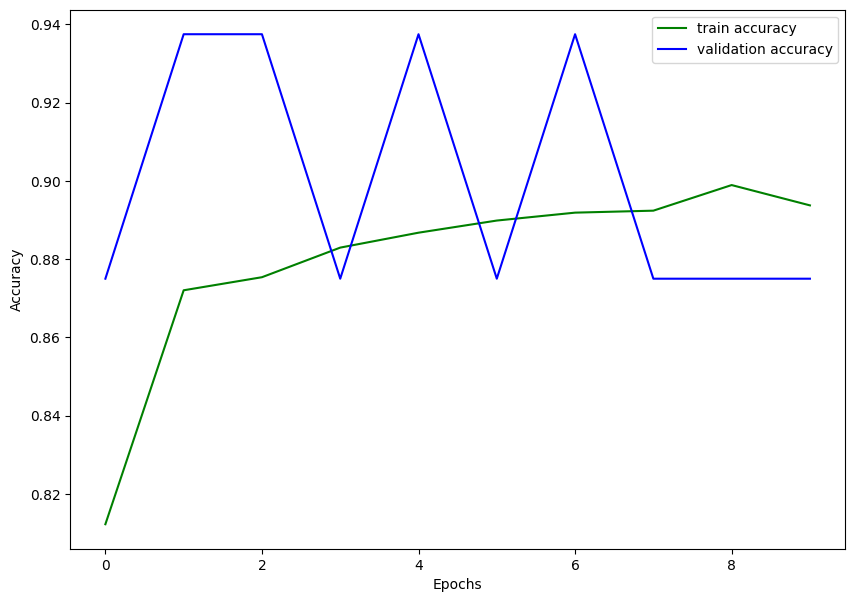

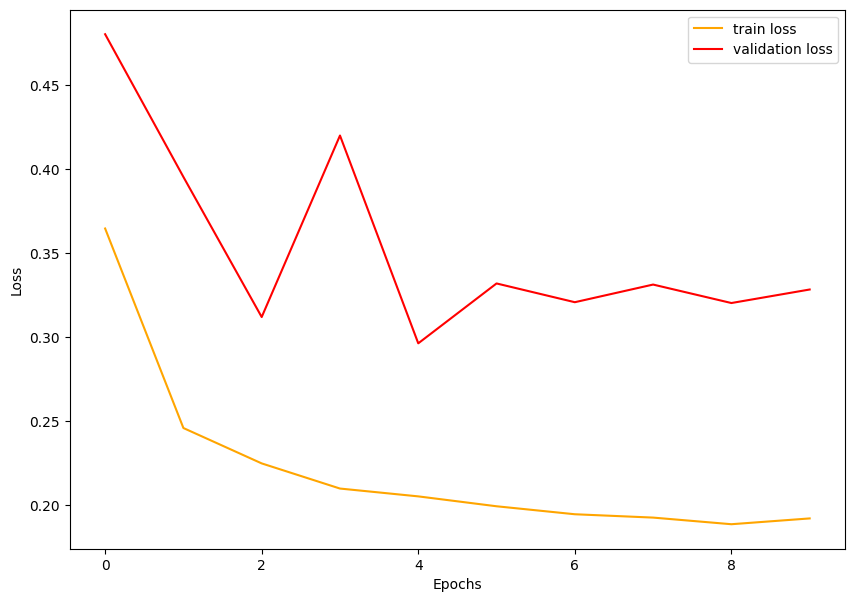

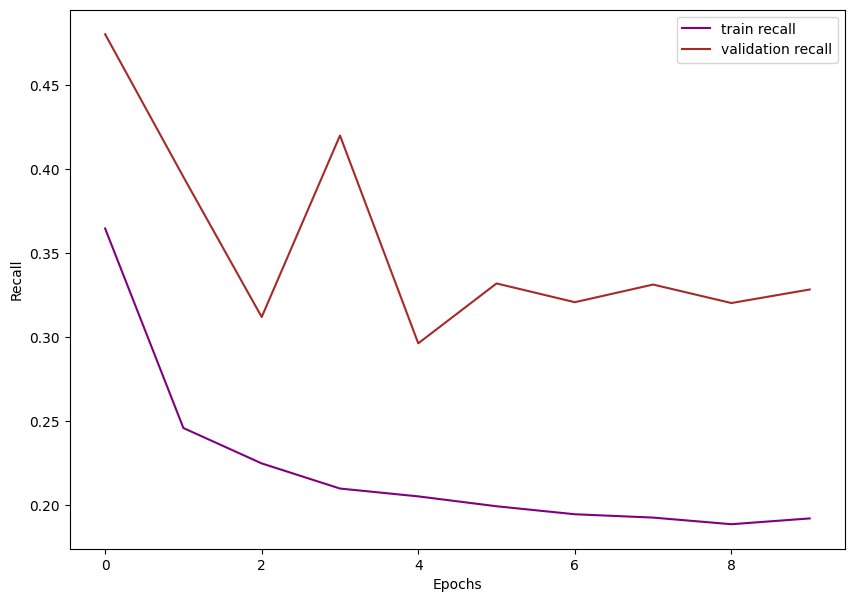

In [40]:
# save the trained model weights
save_model("resnet_transfer.pth", EPOCHS, resnet_model, optimizer, criterion)
# save the loss and accuracy plots
save_plots("resnet_transfer", train_acc, valid_acc, train_loss, valid_loss, train_recall, valid_recall)
print('TRAINING COMPLETE')

## Evaluation <a id="evaluation"></a>

Using `classification_report` from sklearn for evaluation of the model's performance.

In [41]:
from sklearn.metrics import classification_report

### Compute the testing loop and metrics computation

In [42]:
total_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        weights = torch.where(labels==1, POS_WEIGHT, NEG_WEIGHT).view(-1,1).to(DEVICE)
        
        outputs = resnet_model(inputs.to(DEVICE))
        labels = labels.view(-1,1).float().to(DEVICE)
        loss = criterion(outputs, labels)
        loss = (weights * loss).mean()
        
        total_loss += loss.item()

        preds = sigmoid(outputs).round()

        all_labels.extend(labels.squeeze().to('cpu').numpy())
        all_preds.extend(preds.squeeze().to('cpu').numpy())


In [43]:
average_loss = total_loss / len(test_loader.dataset)

print(f'Average Test Loss: {average_loss:.4f}')

Average Test Loss: 0.0064


In [44]:
print(classification_report(all_labels, all_preds, target_names = test_loader.dataset.classes))

              precision    recall  f1-score   support

      NORMAL       0.87      0.82      0.84       234
   PNEUMONIA       0.90      0.93      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



In [46]:
balanced_accuracy_score(all_labels, all_preds)

0.8730769230769231

## Conclusion
Using resampling and transfer learning on ResNet18 model, our new fine-tuned model has improved from 82% to 87%! Nevertheless, there is room for improvement, but I won't be re-experimenting over this dataset for now.
